## AWS Outline for LDA

In [1]:
# Main libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#from sklearn.metrics import accuracy_score, classification_reportt

### Importing Data

In [ ]:
movie_data = pd.read_csv(r"/Users/alexandratorti/DS PROJECT COURSE/Project 2/wiki_movie_plots_deduped.csv")
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


Histogram 

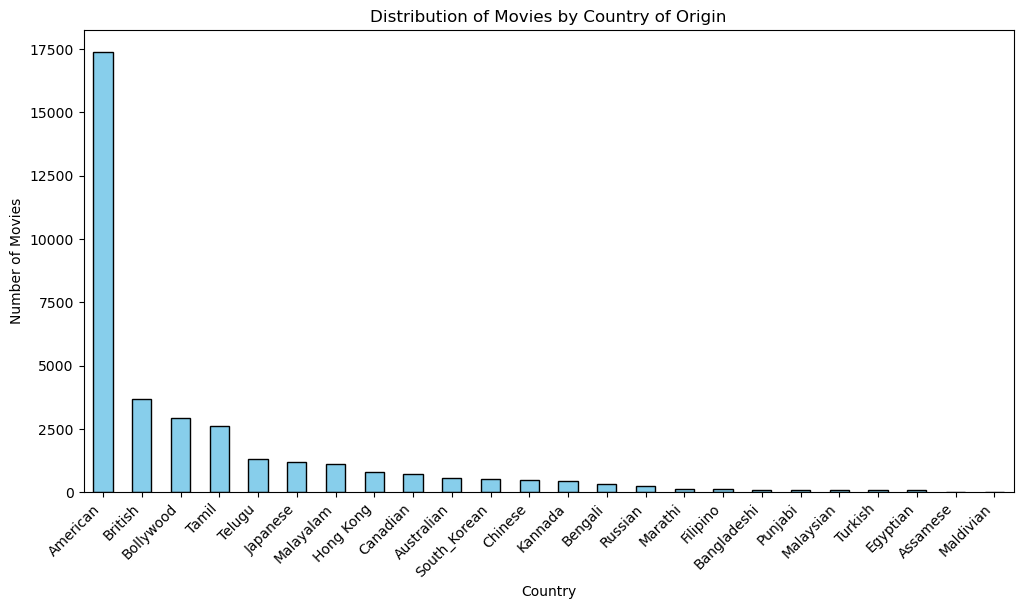

In [ ]:
# Visualize the distribution of movies based on countries
plt.figure(figsize=(12, 6))
movie_data['Origin/Ethnicity'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Movies by Country of Origin')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

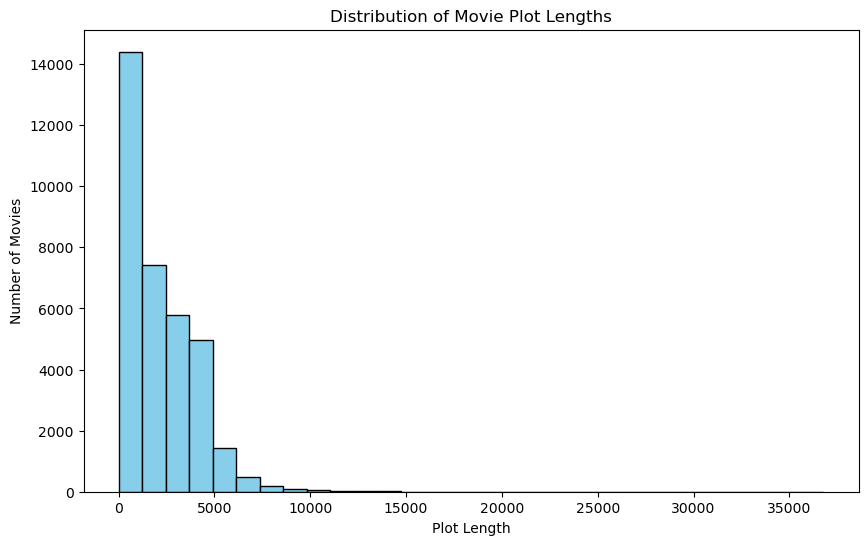

In [ ]:
# Visualize the distribution of plot lengths
plt.figure(figsize=(10, 6))
plt.hist(movie_data['Plot'].str.len(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Plot Lengths')
plt.xlabel('Plot Length')
plt.ylabel('Number of Movies')
plt.show()

### Cleaning Data

In [ ]:
# Select only films that are American in origin
us_movies = movie_data[movie_data['Origin/Ethnicity'] == 'American']

# Drop unwanted columns (Wiki.Page, Director, Cast)
us_movies = us_movies.drop(columns=['Wiki Page', 'Director', 'Cast'])

# Print the summary of the resulting DataFrame
us_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17377 entries, 0 to 17376
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      17377 non-null  int64 
 1   Title             17377 non-null  object
 2   Origin/Ethnicity  17377 non-null  object
 3   Genre             17377 non-null  object
 4   Plot              17377 non-null  object
dtypes: int64(1), object(4)
memory usage: 814.5+ KB


In [ ]:
# Fetch Title and Plot columns
finaldata = us_movies[["Title", "Plot"]]

# Setting the movie title as index
finaldata = finaldata.set_index('Title')
finaldata.head()

,Plot
Title,
Kansas Saloon Smashers,"A bartender is working at a saloon, serving dr..."
Love by the Light of the Moon,"The moon, painted with a smiling face hangs ov..."
The Martyred Presidents,"The film, just over a minute long, is composed..."
"Terrible Teddy, the Grizzly King",Lasting just 61 seconds and consisting of two ...
Jack and the Beanstalk,The earliest known adaptation of the classic f...


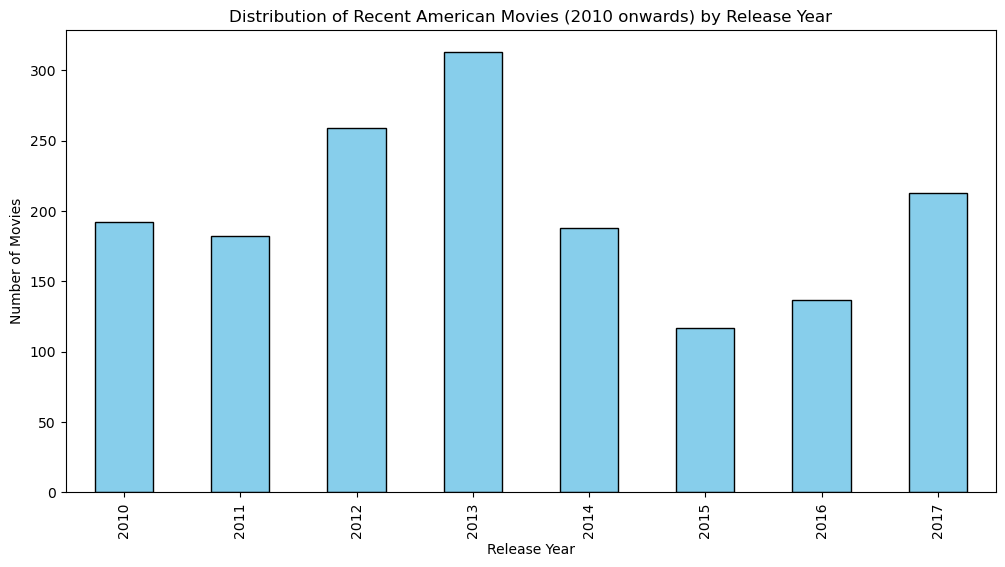

In [ ]:
# Filter for recent years (e.g., from 2010 onwards)
recent_us_movies = us_movies[us_movies['Release Year'] >= 1997]

# Visualize the distribution of recent American movies by year
plt.figure(figsize=(12, 6))
recent_us_movies['Release Year'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Recent American Movies (2010 onwards) by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.show()



### Beginning LDA

In [ ]:
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim


In [ ]:
# create English stop words list
en_stop = get_stop_words('en')

In [ ]:
print(en_stop)

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 't

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

In [ ]:
# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

In [ ]:
plot_set = []
for item in recent_us_movies["Plot"]:
    modified_item = item.replace("\'s", "")  # Corrected line
    plot_set.append(modified_item)

In [ ]:
print(plot_set[0:1])

['Mountaineer Aron Ralston goes hiking at Utah Canyonlands National Park. He befriends hikers Kristi and Megan, and shows them an underground pool. After swimming, Aron parts ways with the hikers, and continues through a slot canyon in Blue John Canyon. While climbing down, he slips and falls, knocking a boulder which smashes his right hand and wrist against the wall. Stuck, he tries calling for help but realizes that he is alone.\r\nRalston begins recording a video diary to maintain morale, chipping away parts of the boulder in order to free himself and to keep warm at night. He rations his food and water, in order to survive the ordeal. He sets up a pulley using his climbing rope in a futile attempt to lift the boulder.\r\nDays pass. Ralston considers using his pocket knife to cut himself free, but finds the dull blade unable to cut bone. With no water, he is forced to drink his urine. His videos become desperate and depressed and he hallucinates about escape, relationships, and past

In [ ]:
# List for tokenized plots in a loop
texts = []

In [ ]:
# Names 

# Assuming your CSV file has a column named 'custom_stop_words'
# Adjust the file path and column name accordingly
csv_file_path = '/Users/alexandratorti/DS PROJECT COURSE/names.csv'
names_df = pd.read_csv(csv_file_path)
names = names_df['name'].str.lower()
names = names.tolist()
print(names)

# First names

# Assuming your CSV file has a column named 'custom_stop_words'
# Adjust the file path and column name accordingly
csv_file_path = '/Users/alexandratorti/DS PROJECT COURSE/Project 2/babynames-clean.csv'
fnames_df = pd.read_csv(csv_file_path)
fnames = fnames_df['name'].str.lower()
fnames = fnames.tolist()
print(fnames)


['smith', 'johnson', 'williams', 'brown', 'jones', 'miller', 'davis', 'garcia', 'rodriguez', 'wilson', 'martinez', 'anderson', 'taylor', 'thomas', 'hernandez', 'moore', 'martin', 'jackson', 'thompson', 'white', 'lopez', 'lee', 'gonzalez', 'harris', 'clark', 'lewis', 'robinson', 'walker', 'perez', 'hall', 'young', 'allen', 'sanchez', 'wright', 'king', 'scott', 'green', 'baker', 'adams', 'nelson', 'hill', 'ramirez', 'campbell', 'mitchell', 'roberts', 'carter', 'phillips', 'evans', 'turner', 'torres', 'parker', 'collins', 'edwards', 'stewart', 'flores', 'morris', 'nguyen', 'murphy', 'rivera', 'cook', 'rogers', 'morgan', 'peterson', 'cooper', 'reed', 'bailey', 'bell', 'gomez', 'kelly', 'howard', 'ward', 'cox', 'diaz', 'richardson', 'wood', 'watson', 'brooks', 'bennett', 'gray', 'james', 'reyes', 'cruz', 'hughes', 'price', 'myers', 'long', 'foster', 'sanders', 'ross', 'morales', 'powell', 'sullivan', 'russell', 'ortiz', 'jenkins', 'gutierrez', 'perry', 'butler', 'barnes', 'fisher', 'henders

In [ ]:
## connecting the lists 
stop_words = en_stop + names + fnames



In [ ]:
print(stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 't

In [ ]:
# Tokenizing loop through plot list
for item in plot_set:
    
    # clean and tokenize document string
    raw = item.lower()
    tokens = tokenizer.tokenize(raw)

    # remove names and stop words from tokens
    #stopped_tokens = [item for item in tokens if item not in names and item not in en_stop]
    
    # remove names from tokens
    #stopped_tokens = [item for item in tokens if not item in names]

    # remove stop words from tokens
    stopped_tokens = [item for item in tokens if not item in stop_words]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(item) for item in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)

In [ ]:
print(tokens)

['in', '1954', 'london', 'renowned', 'fashion', 'designer', 'reynolds', 'woodcock', 'creates', 'dresses', 'for', 'members', 'of', 'high', 'society', 'his', 'charisma', 'and', 'genius', 'are', 'matched', 'by', 'his', 'obsessive', 'controlling', 'and', 'sometimes', 'abusive', 'personality', 'cyril', 'his', 'sister', 'manages', 'the', 'day', 'to', 'day', 'operations', 'of', 'his', 'fashion', 'house', 'and', 'has', 'significant', 'influence', 'over', 'his', 'life', 'reynolds', 'is', 'haunted', 'by', 'the', 'death', 'of', 'their', 'mother', 'and', 'stitches', 'hidden', 'messages', 'into', 'the', 'linings', 'of', 'the', 'dresses', 'he', 'makes', 'after', 'designing', 'a', 'new', 'gown', 'for', 'a', 'revered', 'client', 'reynolds', 'visits', 'a', 'restaurant', 'in', 'the', 'countryside', 'and', 'becomes', 'interested', 'in', 'a', 'waitress', 'alma', 'he', 'asks', 'her', 'on', 'a', 'date', 'and', 'she', 'accepts', 'their', 'relationship', 'develops', 'and', 'she', 'moves', 'in', 'with', 'him',

In [ ]:
print(texts[0:1])

[['mountain', 'ralston', 'goe', 'hike', 'utah', 'canyonland', 'nation', 'befriend', 'hiker', 'show', 'underground', 'pool', 'swim', 'part', 'way', 'hiker', 'continu', 'slot', 'blue', 'climb', 'slip', 'fall', 'knock', 'boulder', 'smash', 'right', 'hand', 'wrist', 'stuck', 'tri', 'call', 'help', 'realiz', 'alon', 'ralston', 'begin', 'record', 'video', 'diari', 'maintain', 'moral', 'chip', 'away', 'part', 'boulder', 'order', 'free', 'keep', 'warm', 'night', 'ration', 'food', 'water', 'order', 'surviv', 'ordeal', 'set', 'pulley', 'use', 'climb', 'rope', 'futil', 'attempt', 'lift', 'boulder', 'day', 'pass', 'ralston', 'consid', 'use', 'pocket', 'knife', 'cut', 'free', 'find', 'dull', 'blade', 'unabl', 'cut', 'bone', 'water', 'forc', 'drink', 'urin', 'video', 'becom', 'desper', 'depress', 'hallucin', 'escap', 'relationship', 'past', 'experi', 'includ', 'former', 'lover', 'famili', 'one', 'hallucin', 'realiz', 'mistak', 'tell', 'anyon', 'go', 'think', 'boulder', 'trap', 'use', 'knowledg', 'to

In [ ]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)

In [ ]:
print(dictionary)

Dictionary<20880 unique tokens: ['65', 'alert', 'alon', 'alway', 'amput']...>


In [ ]:
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.ldamodel import LdaModel

In [ ]:
# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=35, id2word = dictionary, passes=20)

In [ ]:
print(ldamodel.print_topics(num_topics=35, num_words=4))

[(0, '0.011*"kill" + 0.007*"use" + 0.006*"escap" + 0.005*"bomb"'), (1, '0.014*"k" + 0.007*"ship" + 0.007*"kill" + 0.005*"jupit"'), (2, '0.008*"kill" + 0.008*"escap" + 0.007*"katniss" + 0.006*"find"'), (3, '0.013*"s" + 0.009*"nic" + 0.007*"longo" + 0.006*"finkel"'), (4, '0.008*"kill" + 0.005*"escap" + 0.005*"find" + 0.005*"use"'), (5, '0.007*"kill" + 0.005*"tell" + 0.005*"witch" + 0.005*"fight"'), (6, '0.007*"find" + 0.006*"tri" + 0.006*"kill" + 0.005*"take"'), (7, '0.008*"becca" + 0.007*"circu" + 0.006*"use" + 0.005*"find"'), (8, '0.006*"new" + 0.006*"use" + 0.005*"team" + 0.005*"polic"'), (9, '0.009*"kill" + 0.007*"bobo" + 0.006*"lugo" + 0.006*"kershaw"'), (10, '0.009*"bodi" + 0.006*"kill" + 0.006*"giant" + 0.005*"reveal"'), (11, '0.018*"drifter" + 0.011*"s" + 0.009*"rapunzel" + 0.009*"coven"'), (12, '0.016*"kill" + 0.006*"shoot" + 0.006*"find" + 0.006*"polic"'), (13, '0.011*"find" + 0.006*"kill" + 0.006*"take" + 0.005*"see"'), (14, '0.009*"find" + 0.007*"get" + 0.005*"go" + 0.005*"sc

In [ ]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.329767282167837


In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=35, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
# Iterate over possible number of topics. takes about 2-3mins
topic_param = [0,5,10,15,20,25,30,35,40]
coherence_score = []

for k in topic_param:
    cv = compute_coherence_values(corpus=corpus, dictionary=dictionary, k=k)
    coherence_score.append(cv)

param_tuning_coherence = pd.DataFrame()
param_tuning_coherence["topic_param"] = topic_param
param_tuning_coherence['coherence_score'] = coherence_score
param_tuning_coherence

,topic_param,coherence_score
0,0,0.437887
1,5,0.430844
2,10,0.422262
3,15,0.422306
4,20,0.420125
5,25,0.450987
6,30,0.389952
7,35,0.451355
8,40,0.412785


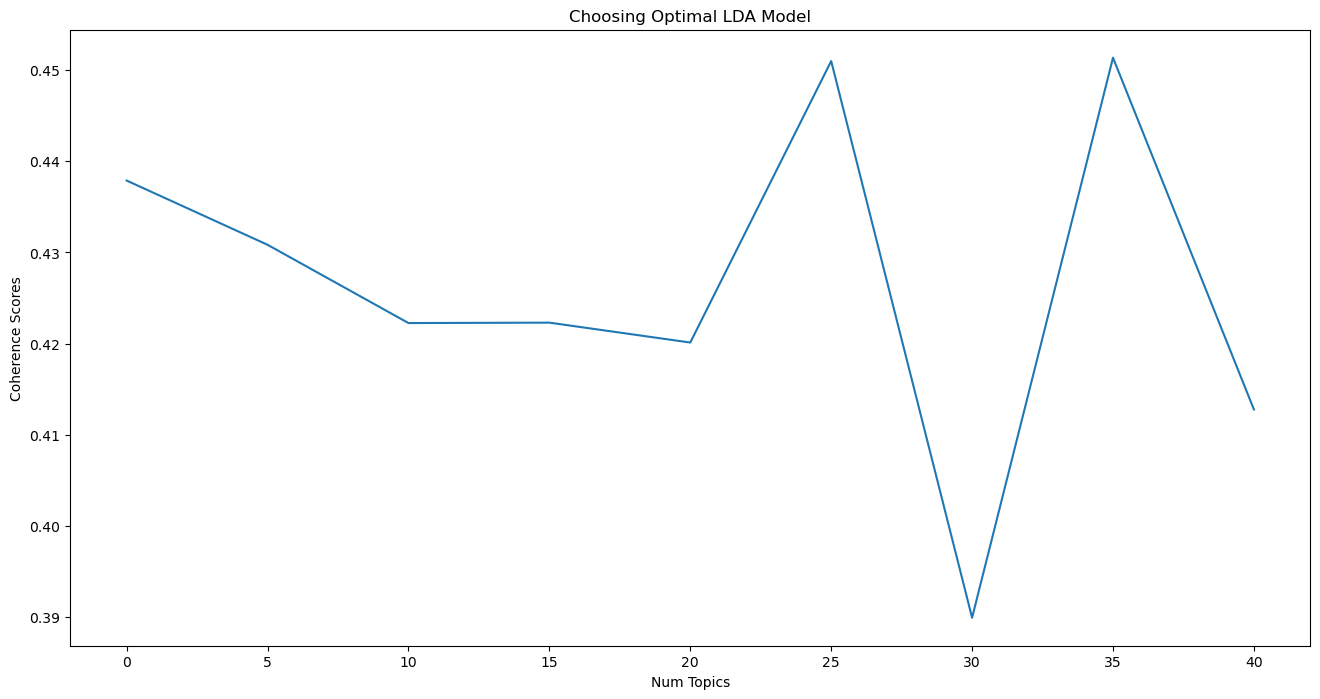

In [ ]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, param_tuning_coherence['coherence_score'])

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

In [ ]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True)) 

In [ ]:
#document topic matrix
doc_num, topic_num, prob = [], [], []
print(ldamodel.get_document_topics(corpus))
for n in range(len(recent_us_movies)):
    get_document_topics = ldamodel.get_document_topics(corpus[n])
    doc_num.append(n)
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
recent_us_movies['Doc'] = doc_num
recent_us_movies['Topic'] = topic_num
recent_us_movies['Probability'] = prob
recent_us_movies.to_csv('doc_topic_matrix.csv', index=False)

/var/folders/55/4w5l1r5x0618j7pxmq4kdgmr0000gn/T/ipykernel_67131/4081826330.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_us_movies['Doc'] = doc_num
/var/folders/55/4w5l1r5x0618j7pxmq4kdgmr0000gn/T/ipykernel_67131/4081826330.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_us_movies['Topic'] = topic_num
/var/folders/55/4w5l1r5x0618j7pxmq4kdgmr0000gn/T/ipykernel_67131/4081826330.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [ ]:
# pyLDAvis.enable_notebook()
# LDAvis_prepared = pyLDAvis.gensim.prepare(ldamodel, corpus, id2word, sort_topics=False)
# LDAvis_prepared

In [ ]:
# Reset the index to move titles back to a column
finaldata_reset = recent_us_movies.reset_index()
finaldata_reset['Title'] = finaldata_reset['Title'].str.title()

# Now, 'Title' is a regular column
print(finaldata_reset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601 entries, 0 to 1600
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             1601 non-null   int64  
 1   Release Year      1601 non-null   int64  
 2   Title             1601 non-null   object 
 3   Origin/Ethnicity  1601 non-null   object 
 4   Genre             1601 non-null   object 
 5   Plot              1601 non-null   object 
 6   Doc               1601 non-null   int64  
 7   Topic             1601 non-null   int64  
 8   Probability       1601 non-null   float32
dtypes: float32(1), int64(4), object(4)
memory usage: 106.4+ KB
None


In [ ]:
#Recomendation Function
def recommend_by_storyline(title):
    recommended = []
    top10_list = []
    title = title.lower()
    finaldata_reset['Title'] = finaldata_reset['Title'].str.lower()
    topic_num = finaldata_reset[finaldata_reset['Title']==title].Topic.values
    doc_num = finaldata_reset[finaldata_reset['Title']==title].Doc.values 
    
    output_df = finaldata_reset[finaldata_reset['Topic']==topic_num[0]].sort_values('Probability', ascending=False).reset_index(drop=True)
    index = output_df[output_df['Doc']==doc_num[0]].index[0]
    
    top10_list += list(output_df.iloc[index-5:index].index)
    # top10_list += list(output_df.iloc[index+1:index+6].index)
    
    output_df['Title'] = output_df['Title'].str.title()
    
    for each in top10_list:
        recommended.append(output_df.iloc[each]['Title'])
    
    return recommended

In [ ]:
# Assuming 'finaldata' is your DataFrame
random_movie = finaldata_reset['Title'].sample().values[0]
print("Random Movie Name:", random_movie)

Random Movie Name: coco


In [ ]:
recommend_by_storyline("Moneyball")

['Race', 'Priest', 'Edge Of Tomorrow', 'Frozen', 'Premium Rush']